<a href="https://colab.research.google.com/github/deviljerry/Project_Encoder-Only_BERT-CustomerFeedbackClassification/blob/main/Encoder_Only(BERT)%E2%80%94CustomerFeedbackClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1: Encoder-Only (BERT) — Customer Feedback Classification
## Objective: Fine-tune a BERT-based model to classify textual feedback according to customer sentiment.

In [19]:
# ====================================================
# Fine-Tuning BERT for Sentiment Classification (Task 1)
# Importing required libraries
# ====================================================

!pip install transformers datasets torch scikit-learn gradio kaggle -q

import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
from torch.optim import AdamW


In [8]:
# ====================================================
# 🔑 Step 1: Setup Kaggle API (make sure you uploaded your kaggle.json)
# ====================================================
# NOTE: You must upload your kaggle.json file in the Colab session first.
# Go to: https://www.kaggle.com/settings -> Create New API Token -> Upload here.

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [10]:
# ====================================================
# 📦 Step 2: Download the dataset automatically from Kaggle
# ====================================================

!kaggle datasets download -d vishweshsalodkar/customer-feedback-dataset -p /content/
!unzip -o /content/customer-feedback-dataset.zip -d /content/



Dataset URL: https://www.kaggle.com/datasets/vishweshsalodkar/customer-feedback-dataset
License(s): other
customer-feedback-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/customer-feedback-dataset.zip
  inflating: /content/sentiment-analysis.csv  


In [16]:
# ====================================================
# 🧹 Step 3: Load and preprocess the dataset (100% FIXED)
# ====================================================

import pandas as pd

# Read as raw single-column text
raw_df = pd.read_csv("/content/sentiment-analysis.csv", header=None, dtype=str, encoding='utf-8', on_bad_lines='skip')
print("Raw shape:", raw_df.shape)

# Drop any completely empty rows
raw_df = raw_df.dropna().reset_index(drop=True)

# First row is header
header_line = raw_df.iloc[0, 0]
header = [h.strip().replace('"', '') for h in header_line.split(",")]
print("Extracted header:", header)

# Extract actual data (skip header)
data_lines = raw_df.iloc[1:, 0].dropna().tolist()

# Split each line into columns safely
split_rows = []
for line in data_lines:
    try:
        parts = [p.strip().replace('"', '') for p in line.split(",")]
        # Sometimes there are more than 7 commas; only keep the first two fields we need
        if len(parts) >= 2:
            split_rows.append(parts[:7])
    except Exception as e:
        continue

# Convert into DataFrame
df = pd.DataFrame(split_rows, columns=header[:len(split_rows[0])])
print("\n✅ After manual split:")
print(df.head())

# Keep only 'Text' and 'Sentiment'
df = df[["Text", "Sentiment"]].copy()

# Clean text and labels
df["Text"] = df["Text"].astype(str).str.strip()
df["Sentiment"] = df["Sentiment"].astype(str).str.strip().str.capitalize()

# Rename for model
df = df.rename(columns={"Text": "review", "Sentiment": "label"})

# Encode labels numerically
label_map = {"Positive": 2, "Neutral": 1, "Negative": 0}
df["label"] = df["label"].map(label_map)

# Drop invalid rows
df = df.dropna(subset=["review", "label"]).reset_index(drop=True)

# Split into train/validation
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

print(f"\n✅ Cleaned Data — Train: {len(train_df)} | Validation: {len(val_df)}")
print(train_df.head())


Raw shape: (99, 1)
Extracted header: ['Text', 'Sentiment', 'Source', 'Date/Time', 'User ID', 'Location', 'Confidence Score']

✅ After manual split:
                                               Text Sentiment        Source  \
0                              I love this product!  Positive       Twitter   
1                         The service was terrible.  Negative  Yelp Reviews   
2                            This movie is amazing!  Positive          IMDb   
3  I'm so disappointed with their customer support.  Negative  Online Forum   
4                Just had the best meal of my life!  Positive   TripAdvisor   

             Date/Time      User ID     Location Confidence Score  
0  2023-06-15 09:23:14     @user123     New York             0.85  
1  2023-06-15 11:45:32      user456  Los Angeles             0.65  
2  2023-06-15 14:10:22  moviefan789       London             0.92  
3  2023-06-15 17:35:11   forumuser1      Toronto             0.78  
4  2023-06-16 08:50:59     foodie22  

In [17]:
# ====================================================
# 🧩 Step 4: Tokenization
# ====================================================

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
MAX_LEN = 128

class FeedbackDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = FeedbackDataset(train_df['review'].tolist(), train_df['label'].tolist(), tokenizer, MAX_LEN)
val_dataset = FeedbackDataset(val_df['review'].tolist(), val_df['label'].tolist(), tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
# ====================================================
# ⚙️ Step 5: Model Setup (FINAL FIXED VERSION)
# ====================================================

import torch
from torch.optim import AdamW                     # ✅ Correct AdamW import
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Device in use:", device)

# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.to(device)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)   # ✅ Now correctly defined
epochs = 2
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print("✅ Model, optimizer, and scheduler ready for training!")


✅ Device in use: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model, optimizer, and scheduler ready for training!


In [21]:
# ====================================================
# 🧠 Step 6: Training Loop
# ====================================================

def train_model(model, train_loader, val_loader, optimizer, scheduler, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            optimizer.zero_grad()
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()
        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}")
    return model

model = train_model(model, train_loader, val_loader, optimizer, scheduler, epochs)



Training Epoch 1:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 1.0612


Training Epoch 2:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 0.8841


Evaluating:   0%|          | 0/2 [00:00<?, ?it/s]


✅ Evaluation Metrics:
Accuracy: 0.6500
F1 Score: 0.5809

Classification Report:
              precision    recall  f1-score   support

    negative       1.00      0.22      0.36         9
    positive       0.61      1.00      0.76        11

    accuracy                           0.65        20
   macro avg       0.81      0.61      0.56        20
weighted avg       0.79      0.65      0.58        20



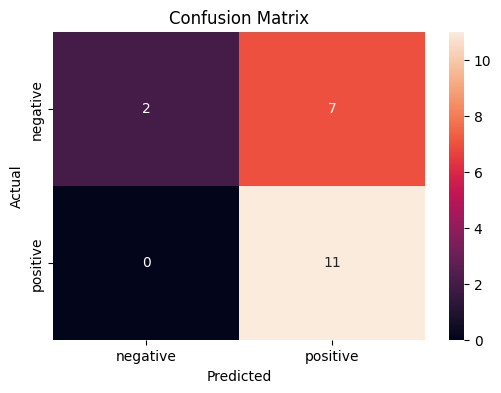

In [23]:
# ====================================================
# 📊 Step 7: Evaluation (FINAL SMART VERSION)
# ====================================================

model.eval()
preds, true_labels = [], []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Evaluating"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1).cpu().numpy()
        labels = batch['labels'].cpu().numpy()
        preds.extend(predictions)
        true_labels.extend(labels)

acc = accuracy_score(true_labels, preds)
f1 = f1_score(true_labels, preds, average='weighted')
cm = confusion_matrix(true_labels, preds)

print("\n✅ Evaluation Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

# 🔍 Detect number of unique labels dynamically
unique_labels = sorted(list(set(true_labels + preds)))
label_names_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
target_names = [label_names_map[i] for i in unique_labels if i in label_names_map]

print("\nClassification Report:")
print(classification_report(true_labels, preds, target_names=target_names))

# 🧾 Confusion Matrix Visualization
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=target_names,
            yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [24]:
# ====================================================
# 🤖 Step 8: Gradio Interface for Real-Time Prediction
# ====================================================

def predict_sentiment(text):
    model.eval()
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        logits = model(**inputs).logits
    pred = torch.argmax(logits, dim=-1).item()
    label_decode = {0:'Negative 😠', 1:'Neutral 😐', 2:'Positive 😊'}
    return label_decode[pred]

demo = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=2, placeholder="Enter customer feedback here..."),
    outputs="text",
    title="BERT Sentiment Classifier",
    description="Fine-tuned BERT model for real-time customer feedback sentiment classification."
)

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://58e7a09766bde87cc9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
